In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from rasterio.plot import show
from tensorflow.keras import layers, models

In [2]:
# Load CSV data
csv_path = "s1_data.csv"  
df = pd.read_csv(csv_path)  
df['geometry'] = df['geometry'].apply(eval) 

df.head()

,geometry,label,date,tile_number,id,location_id,image_dir
0,"[[[-13.278048, 8.493532], [-13.278254, 8.44724...",0,2018-12-23,1,sen12floods_s1_labels_0001_2018_12_23,1,sen12flood/sen12floods_s1_source/sen12floods_s...
1,"[[[-13.278048, 8.493532], [-13.278254, 8.44724...",0,2019-01-04,1,sen12floods_s1_labels_0001_2019_01_04,1,sen12flood/sen12floods_s1_source/sen12floods_s...
2,"[[[-13.278048, 8.493532], [-13.278254, 8.44724...",0,2019-01-16,1,sen12floods_s1_labels_0001_2019_01_16,1,sen12flood/sen12floods_s1_source/sen12floods_s...
3,"[[[-13.278048, 8.493532], [-13.278254, 8.44724...",0,2019-01-28,1,sen12floods_s1_labels_0001_2019_01_28,1,sen12flood/sen12floods_s1_source/sen12floods_s...
4,"[[[18.627334, -33.849575], [18.626057, -33.895...",0,2018-12-16,4,sen12floods_s1_labels_0004_2018_12_16,4,sen12flood/sen12floods_s1_source/sen12floods_s...


In [3]:
def load_tiff(image_dir):
    vv_path = os.path.join(image_dir, "VV.tif")
    vh_path = os.path.join(image_dir, "VH.tif")

    with rasterio.open(vv_path) as vv, rasterio.open(vh_path) as vh:
        vv_band = vv.read(1)  
        vh_band = vh.read(1)  

    # Stack VV and VH bands to create a 2-channel image
    img = np.stack([vv_band, vh_band], axis=-1)
    
    # Normalize to [0, 1]
    img = (img - img.min()) / (img.max() - img.min())

    return img

# Example usage
example_image = load_tiff(df['image_dir'].iloc[0])
print("Image shape:", example_image.shape)

Image shape: (518, 521, 2)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from rasterio.features import rasterize

In [5]:
image_size = (64, 64)  
batch_size = 8

def load_tiff(image_dir):
    """
    Load VV and VH Sentinel-1 images as a 2-channel NumPy array.
    """
    try:
        # Construct file paths for VV & VH images
        vv_path = os.path.join(image_dir, "VV.tif")
        vh_path = os.path.join(image_dir, "VH.tif")

        # Load VV band
        with rasterio.open(vv_path) as vv:
            vv_image = vv.read(1)  # Read first band (grayscale)

        # Load VH band
        with rasterio.open(vh_path) as vh:
            vh_image = vh.read(1)  # Read first band (grayscale)

        # Normalize the images (optional)
        vv_image = (vv_image - vv_image.min()) / (vv_image.max() - vv_image.min() + 1e-6)
        vh_image = (vh_image - vh_image.min()) / (vh_image.max() - vh_image.min() + 1e-6)

        print(f"Succesfully loaded {image_dir}")

        # Stack VV & VH as separate channels
        img = np.stack([vv_image, vh_image], axis=-1)  # Shape: (H, W, 2)
        
        return img

    except Exception as e:
        print(f"Error loading images from {image_dir}: {e}")
        return None 

In [6]:
def create_mask(geometry, shape=(64, 64)):
    try:
        # Ensure `geometry` is properly structured
        if isinstance(geometry[0], list):  
            coordinates = geometry[0]  # Extract the first list
        else:
            coordinates = geometry  

        # Convert to Polygon
        polygon = Polygon(coordinates).simplify(0.0001, preserve_topology=True)

        # Rasterize (optimized with NumPy)
        mask = rasterize(
            [(polygon, 1)],  # List of tuples (geometry, value)
            out_shape=shape,
            fill=0,
            dtype=np.uint8
        )
        
        print(f"Created mask for {geometry}")
        return mask

    except Exception as e:
        print(f"Error creating mask from geometry {geometry}: {e}")
        return None  

In [7]:
# Data Preprocessing
def preprocess_data(row):
    img = load_tiff(row['image_dir'])
    
    if img is None or np.isnan(img).any():
        print(f"Warning: Issue loading {row['image_dir']}, replacing with zeros.")
        img = np.zeros((*image_size, 2), dtype=np.float32)  # 2 channels (VV, VH)

    mask = create_mask(row['geometry'])
    
    if mask is None or np.isnan(mask).any():
        print(f"Warning: Mask issue at {row['geometry']}, replacing with zeros.")
        mask = np.zeros(image_size, dtype=np.uint8)

    # Resize Image (Keep 2 channels)
    img = cv2.resize(img, image_size)  
    
    # Resize Mask
    mask = cv2.resize(mask, image_size)

    return img, mask

# Process Entire Dataset
images, masks = zip(*df.apply(preprocess_data, axis=1))
images, masks = np.array(images), np.array(masks)

# Expand dimensions for model input (masks should be (H, W, 1))
masks = np.expand_dims(masks, axis=-1)

Succesfully loaded sen12flood/sen12floods_s1_source/sen12floods_s1_source//sen12floods_s1_source_0001_2018_12_23
Created mask for [[[-13.278048, 8.493532], [-13.278254, 8.447241], [-13.231762, 8.447033], [-13.231551, 8.493323], [-13.278048, 8.493532]]]
Succesfully loaded sen12flood/sen12floods_s1_source/sen12floods_s1_source//sen12floods_s1_source_0001_2019_01_04
Created mask for [[[-13.278048, 8.493532], [-13.278254, 8.447241], [-13.231762, 8.447033], [-13.231551, 8.493323], [-13.278048, 8.493532]]]
Succesfully loaded sen12flood/sen12floods_s1_source/sen12floods_s1_source//sen12floods_s1_source_0001_2019_01_16
Created mask for [[[-13.278048, 8.493532], [-13.278254, 8.447241], [-13.231762, 8.447033], [-13.231551, 8.493323], [-13.278048, 8.493532]]]
Succesfully loaded sen12flood/sen12floods_s1_source/sen12floods_s1_source//sen12floods_s1_source_0001_2019_01_28
Created mask for [[[-13.278048, 8.493532], [-13.278254, 8.447241], [-13.231762, 8.447033], [-13.231551, 8.493323], [-13.278048, 

In [8]:
from sklearn.model_selection import train_test_split

# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [9]:
X_train = np.array(X_train)
y_train = np.array(y_train)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
                 .shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))\
               .batch(batch_size).prefetch(tf.data.AUTOTUNE)
train_dataset = train_dataset.map(lambda x, y: (tf.cast(x, tf.float16), tf.cast(y, tf.float16)))
val_dataset = val_dataset.map(lambda x, y: (tf.cast(x, tf.float16), tf.cast(y, tf.float16)))

In [10]:
def model():
        global train_dataset, val_dataset, X_val, y_val
    
        def swin_unet(input_shape=(64, 64, 2)):
            inputs = Input(shape=input_shape)
    
            # Project to 3 channels if needed
            if input_shape[-1] != 3:
                x = layers.Conv2D(3, (1, 1), padding='same')(inputs)
            else:
                x = inputs

            # Swin Transformer Backbone
            swin_config = SwinConfig(image_size=input_shape[0], num_channels=3, return_dict=True)
            swin = TFSwinModel(swin_config)
            swin_outputs = swin(x).last_hidden_state  # (batch, num_patches, hidden_dim)

            patch_dim = input_shape[0] // 4
            embed_dim = swin_config.hidden_size
            x = layers.Reshape((patch_dim, patch_dim, embed_dim))(swin_outputs)

            # Decoder
            u1 = layers.UpSampling2D((2, 2))(x)
            u1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)

            u2 = layers.UpSampling2D((2, 2))(u1)
            u2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)

            u3 = layers.UpSampling2D((2, 2))(u2)
            u3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u3)

            outputs = layers.Conv2D(1, (1, 1), activation='sigmoid', dtype='float32')(u3)

            return models.Model(inputs=inputs, outputs=outputs)

    
        # Initialize model, loss, optimizer
        model = swin_unet()
        loss_fn = tf.keras.losses.BinaryCrossentropy()
        optimizer = mixed_precision.LossScaleOptimizer(tf.keras.optimizers.Adam(1e-4))
    
        # Track metrics
        train_acc_list, val_acc_list = [], []
        train_loss_list, val_loss_list = [], []
        f1_score_list = []
    
        # Training loop
        EPOCHS = 50
        for epoch in range(EPOCHS):
            print(f"\nEpoch {epoch+1}/{EPOCHS}")
            progbar = tqdm(train_dataset, desc="", leave=False)
    
            train_acc = tf.keras.metrics.BinaryAccuracy()
            train_loss_avg = tf.keras.metrics.Mean()
    
            # Training steps
            for step, (x_batch, y_batch) in enumerate(progbar):
                with tf.GradientTape() as tape:
                    logits = model(x_batch, training=True)
                    loss = loss_fn(y_batch, logits)
                    scaled_loss = optimizer.get_scaled_loss(loss)
    
                scaled_grads = tape.gradient(scaled_loss, model.trainable_variables)
                grads = optimizer.get_unscaled_gradients(scaled_grads)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
                train_loss_avg.update_state(loss)
                train_acc.update_state(y_batch, logits)
    
                progbar.set_description(f"{step+1}/{len(train_dataset)}")
    
            # Save train metrics
            train_loss_list.append(train_loss_avg.result().numpy())
            train_acc_list.append(train_acc.result().numpy())
    
            # Validation loop
            val_logits = []
            val_labels = []
            val_acc = tf.keras.metrics.BinaryAccuracy()
            val_loss_avg = tf.keras.metrics.Mean()
    
            for x_batch, y_batch in val_dataset:
                preds = model(x_batch, training=False)
                val_logits.append(preds.numpy().flatten())
                val_labels.append(y_batch.numpy().flatten())
                val_loss_avg.update_state(loss_fn(y_batch, preds))
                val_acc.update_state(y_batch, preds)
    
            y_pred_all = np.concatenate(val_logits)
            y_true_all = np.concatenate(val_labels)
            y_pred_binary = (y_pred_all > 0.5).astype(int)
    
            f1 = f1_score(y_true_all, y_pred_binary, average='binary')
            f1_score_list.append(f1)
            val_loss_list.append(val_loss_avg.result().numpy())
            val_acc_list.append(val_acc.result().numpy())
    
            print("Data Updated")
    
        return {
            'train_loss': train_loss_list,
            'train_accuracy': train_acc_list,
            'val_loss': val_loss_list,
            'val_accuracy': val_acc_list,
            'f1_score': f1_score_list
        }

In [11]:
metrics = model()


Epoch 1/50


Data Updated

Epoch 2/50


Data Updated

Epoch 3/50


Data Updated

Epoch 4/50


Data Updated

Epoch 5/50


Data Updated

Epoch 6/50


Data Updated

Epoch 7/50


Data Updated

Epoch 8/50


Data Updated

Epoch 9/50


Data Updated

Epoch 10/50


Data Updated

Epoch 11/50


Data Updated

Epoch 12/50


Data Updated

Epoch 13/50


Data Updated

Epoch 14/50


Data Updated

Epoch 15/50


Data Updated

Epoch 16/50


Data Updated

Epoch 17/50


Data Updated

Epoch 18/50


Data Updated

Epoch 19/50


Data Updated

Epoch 20/50


Data Updated

Epoch 21/50


Data Updated

Epoch 22/50


Data Updated

Epoch 23/50


Data Updated

Epoch 24/50


Data Updated

Epoch 25/50


Data Updated

Epoch 26/50


Data Updated

Epoch 27/50


Data Updated

Epoch 28/50


Data Updated

Epoch 29/50


Data Updated

Epoch 30/50


Data Updated

Epoch 31/50


Data Updated

Epoch 32/50


Data Updated

Epoch 33/50


Data Updated

Epoch 34/50


Data Updated

Epoch 35/50


Data Updated

Epoch 36/50


Data Updated

Epoch 37/50


Data Updated

Epoch 38/50


Data Updated

Epoch 39/50


Data Updated

Epoch 40/50


Data Updated

Epoch 41/50


Data Updated

Epoch 42/50


Data Updated

Epoch 43/50


Data Updated

Epoch 44/50


Data Updated

Epoch 45/50


Data Updated

Epoch 46/50


Data Updated

Epoch 47/50


Data Updated

Epoch 48/50


Data Updated

Epoch 49/50


Data Updated

Epoch 50/50


Data Updated


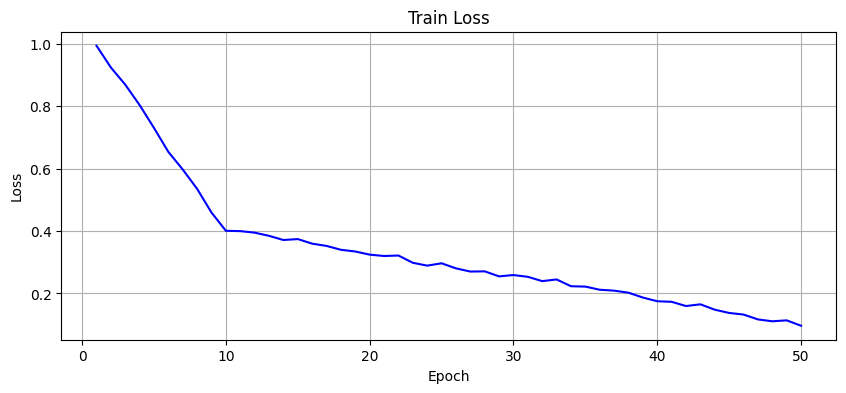

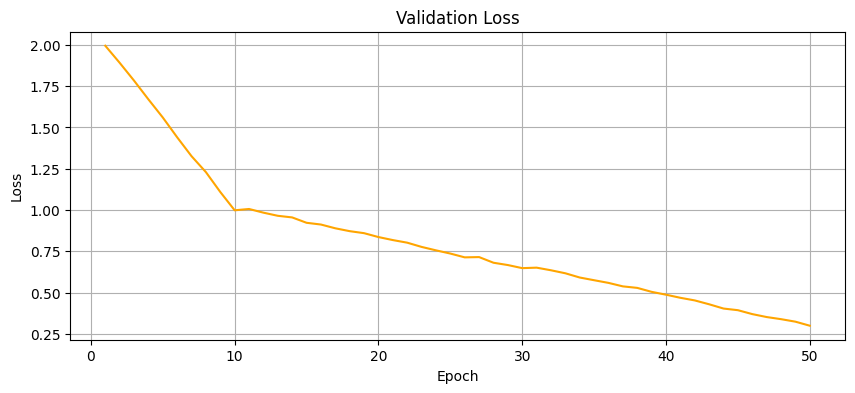

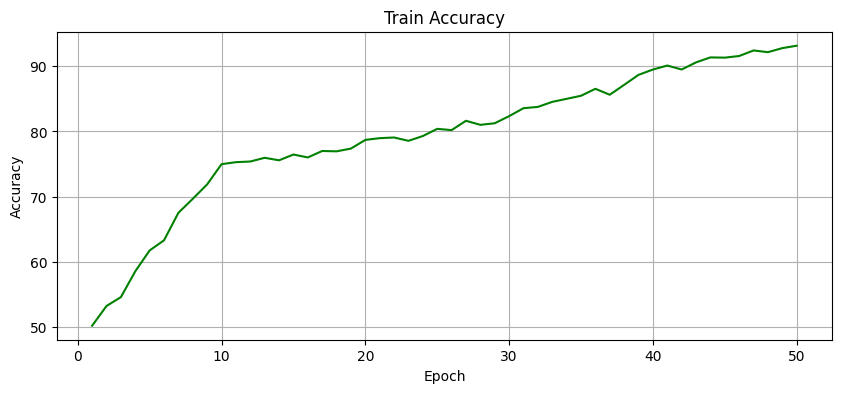

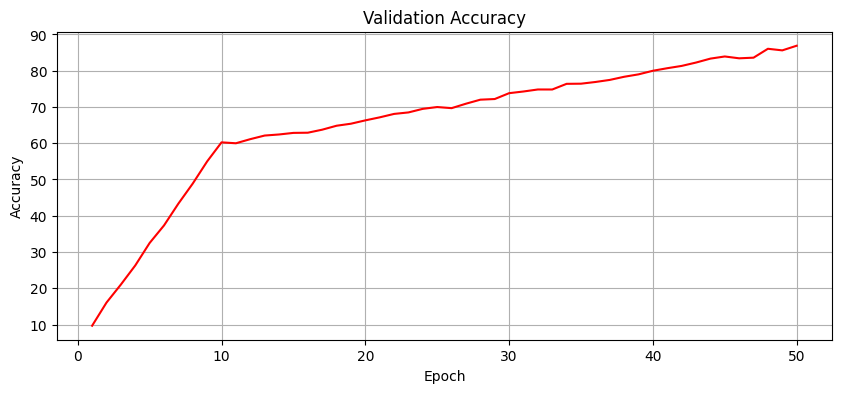

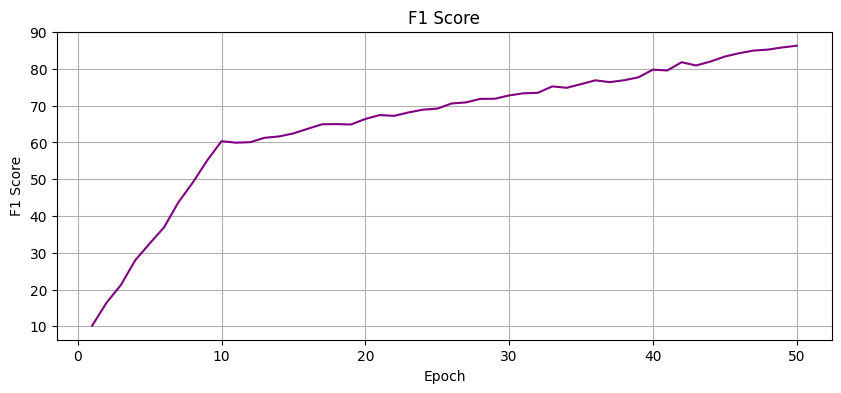

In [12]:
epochs = range(1, len(train_loss_list) + 1)

# Train Loss
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_loss_list, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.grid(True)
plt.show()

# Validation Loss
plt.figure(figsize=(10, 4))
plt.plot(epochs, val_loss_list, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.grid(True)
plt.show()

# Train Accuracy
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_acc_list, label='Train Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train Accuracy')
plt.grid(True)
plt.show()

# Validation Accuracy
plt.figure(figsize=(10, 4))
plt.plot(epochs, val_acc_list, label='Val Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.grid(True)
plt.show()

# F1 Score
plt.figure(figsize=(10, 4))
plt.plot(epochs, f1_score_list, label='F1 Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score')
plt.grid(True)
plt.show()

In [13]:
epoch_idx = 49  

print(f"Train Loss (Epoch 50): {train_loss_list[epoch_idx]:.4f}")
print(f"Validation Loss (Epoch 50): {val_loss_list[epoch_idx]:.4f}")
print(f"Training Accuracy (Epoch 50): {train_acc_list[epoch_idx]:.4f}")
print(f"Validation Accuracy (Epoch 50): {val_acc_list[epoch_idx]:.4f}")
print(f"F1 Score (Epoch 50): {f1_score_list[epoch_idx]:.4f}")

Train Loss (Epoch 50): 0.0967
Validation Loss (Epoch 50): 0.3001
Training Accuracy (Epoch 50): 93.1608
Validation Accuracy (Epoch 50): 86.8876
F1 Score (Epoch 50): 86.2963
